In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.decision_tree import DecisionTree

# Load saved dataset
DATASET_PATH = "../data/cifar_dataset.pt"
data = torch.load(DATASET_PATH)

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
n_classes = data['n_classes']

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {n_classes}")


Train set: X=torch.Size([50000, 36]), y=torch.Size([50000])
Test set: X=torch.Size([10000, 36]), y=torch.Size([10000])
Number of features: 36
Number of classes: 10


/tmp/ipykernel_76428/3136235676.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(DATASET_PATH)


In [2]:
# Train the model
tree_clf = DecisionTree(
    classification=True,
    max_depth=10,
    min_samples_split=2,
    criterion="gini",
    device="cpu",
)
tree_clf.fit(X_train, y_train)
print("Model trained successfully!")


Model trained successfully!


In [3]:
# Make predictions
y_train_pred = tree_clf.predict(X_train)
y_test_pred = tree_clf.predict(X_test)

# Calculate accuracy
train_accuracy = (y_train == y_train_pred).float().mean().item()
test_accuracy = (y_test == y_test_pred).float().mean().item()

print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print("\nTest Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")


Training Metrics:
  Accuracy: 0.4018

Test Metrics:
  Accuracy: 0.3184


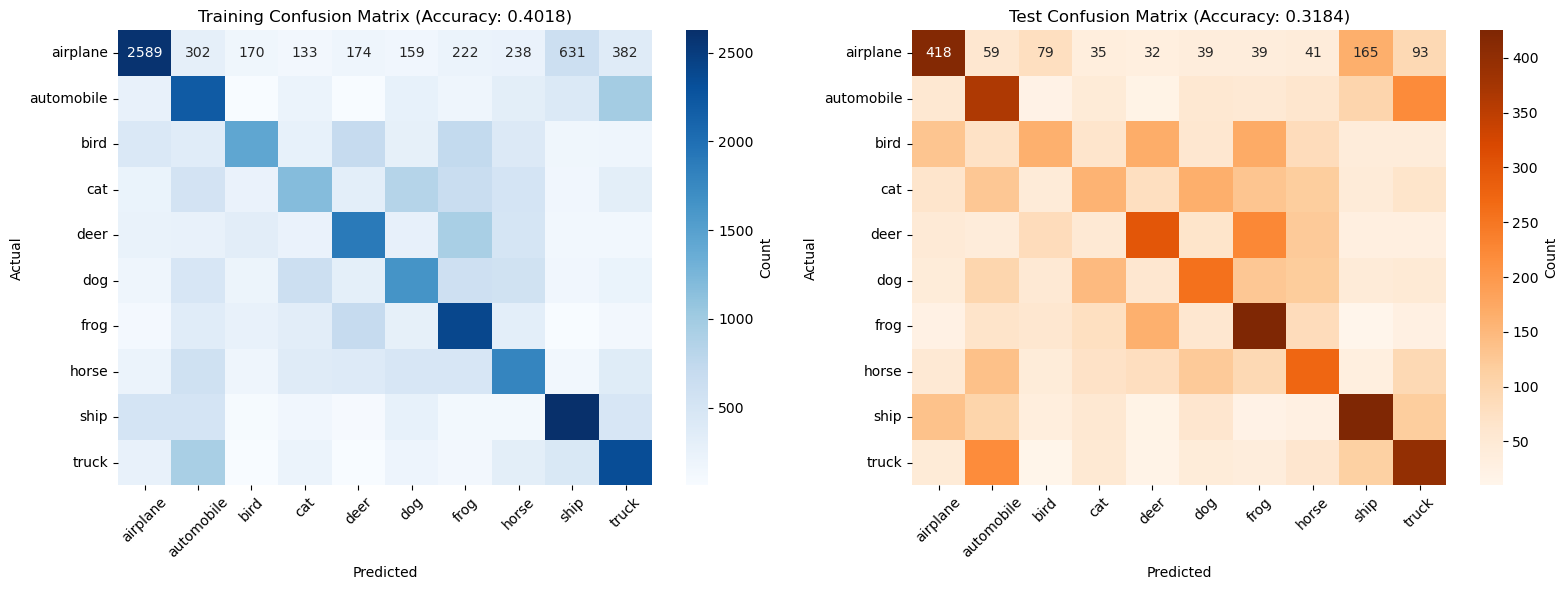

In [4]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Convert to numpy for sklearn
y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
y_train_pred_np = y_train_pred.numpy() if isinstance(y_train_pred, torch.Tensor) else y_train_pred
y_test_pred_np = y_test_pred.numpy() if isinstance(y_test_pred, torch.Tensor) else y_test_pred

# Create confusion matrices
cm_train = confusion_matrix(y_train_np, y_train_pred_np)
cm_test = confusion_matrix(y_test_np, y_test_pred_np)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Training Confusion Matrix (Accuracy: {train_accuracy:.4f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Test Confusion Matrix (Accuracy: {test_accuracy:.4f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


In [5]:
# Per-class accuracy
from sklearn.metrics import classification_report

print("Training Set - Per-class Metrics:")
print(classification_report(y_train_np, y_train_pred_np, target_names=class_names, digits=4))
print("\nTest Set - Per-class Metrics:")
print(classification_report(y_test_np, y_test_pred_np, target_names=class_names, digits=4))


Training Set - Per-class Metrics:
              precision    recall  f1-score   support

    airplane     0.5124    0.5178    0.5151      5000
  automobile     0.3358    0.4392    0.3806      5000
        bird     0.4722    0.2872    0.3572      5000
         cat     0.3123    0.2350    0.2682      5000
        deer     0.4001    0.3796    0.3896      5000
         dog     0.3492    0.3280    0.3383      5000
        frog     0.3696    0.4806    0.4178      5000
       horse     0.3483    0.3574    0.3528      5000
        ship     0.5289    0.5252    0.5270      5000
       truck     0.4204    0.4682    0.4430      5000

    accuracy                         0.4018     50000
   macro avg     0.4049    0.4018    0.3990     50000
weighted avg     0.4049    0.4018    0.3990     50000


Test Set - Per-class Metrics:
              precision    recall  f1-score   support

    airplane     0.4106    0.4180    0.4143      1000
  automobile     0.2819    0.3650    0.3181      1000
        bird 

In [6]:
# Learning curves: performance vs max_depth
depths = list(range(1, 16))
train_acc_scores = []
test_acc_scores = []

print("Training models with different max_depth values...")
for depth in depths:
    # Train model with current depth
    tree = DecisionTree(
        classification=True,
        max_depth=depth,
        min_samples_split=2,
        criterion="gini",
        device="cpu",
    )
    tree.fit(X_train, y_train)
    
    # Predictions
    y_train_pred_curve = tree.predict(X_train)
    y_test_pred_curve = tree.predict(X_test)
    
    # Calculate accuracy
    train_acc = (y_train == y_train_pred_curve).float().mean().item()
    test_acc = (y_test == y_test_pred_curve).float().mean().item()
    
    train_acc_scores.append(train_acc)
    test_acc_scores.append(test_acc)

print("Done!")


Training models with different max_depth values...
Done!


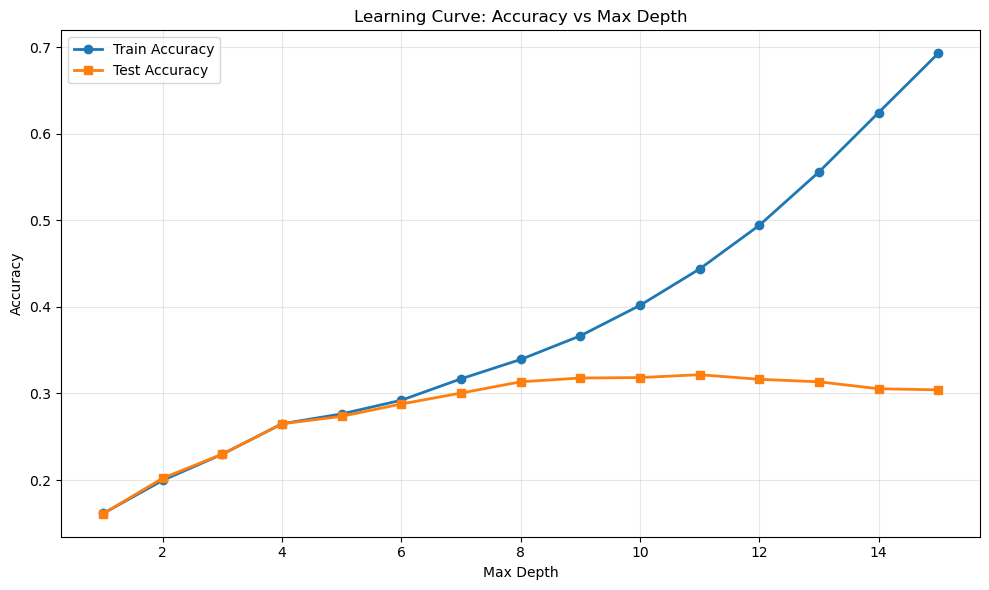


Best max_depth based on test accuracy: 11
Best test accuracy: 0.3217
Corresponding train accuracy: 0.4439


In [7]:
# Plot learning curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(depths, train_acc_scores, 'o-', label='Train Accuracy', linewidth=2, markersize=6)
ax.plot(depths, test_acc_scores, 's-', label='Test Accuracy', linewidth=2, markersize=6)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curve: Accuracy vs Max Depth')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best depth
best_test_idx = np.argmax(test_acc_scores)
best_depth = depths[best_test_idx]
print(f"\nBest max_depth based on test accuracy: {best_depth}")
print(f"Best test accuracy: {test_acc_scores[best_test_idx]:.4f}")
print(f"Corresponding train accuracy: {train_acc_scores[best_test_idx]:.4f}")
